In [1]:
!conda install -y quantecon

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [2]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import pandas as pd
import statistics as stat
from scipy.stats import norm
from numpy.linalg import eigvals, solve

## Built-in functions of Markov-chains

In [15]:
P = np.array([[0.5, 0.1, 0.4],
            [0.15, 0.7, 0.15],
            [0.3, 0.1, 0.6]])

mc = qe.MarkovChain(P, state_values=('p', 's', 'l'))
mc.simulate(10)

array(['l', 's', 's', 's', 's', 's', 'p', 'l', 'l', 'l'], dtype='<U1')

In [4]:
mc.stationary_distributions

array([[0.328125, 0.25    , 0.421875]])

In [5]:
P = np.array([[0.5, 0.1, 0.4],
            [0.15, 0.7, 0.15],
            [0.3, 0.1, 0.6]])

μ = [0.2, 0.35, 0.45]

mc = qe.MarkovChain(P)
mc.simulate(10, init = np.random.choice([0, 1, 2], p = μ))

array([2, 2, 2, 2, 2, 1, 1, 1, 1, 2])

In [6]:
P = np.array([[0, 1/2, 1/2, 0, 0],
            [1/3, 1/3, 0, 1/3, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1/2, 1/2, 0]])

mc = qe.MarkovChain(P,['A','B','C','D','E'])
mc.communication_classes

[array(['C', 'D'], dtype='<U1'),
 array(['A', 'B'], dtype='<U1'),
 array(['E'], dtype='<U1')]

In [7]:
mc.is_irreducible

False

In [8]:
P = np.array([[0.5, 0.1, 0.4],
            [0.15, 0.7, 0.15],
            [0.3, 0.1, 0.6]])
mc = qe.MarkovChain(P)
mc.period

1

In [9]:
mc.is_aperiodic

True

In [10]:
P = np.array([[0.5, 0.1, 0.4],
            [0.15, 0.7, 0.15],
            [0.3, 0.1, 0.6]])

mc = qe.MarkovChain(P)
mc.stationary_distributions

array([[0.328125, 0.25    , 0.421875]])

In [11]:
μ_1 = np.array([0.25, 0.25, 0.5])
np.matmul(μ_1,np.linalg.matrix_power(P, 10))

array([0.32812499, 0.25      , 0.42187501])

In [12]:
μ_2 = np.array([1/3, 1/3, 1/3])
np.matmul(μ_2,np.linalg.matrix_power(P, 30))

array([0.32812499, 0.25000002, 0.42187499])

## Markov-chain based on historical data

In [16]:
def create_mc(dividends: int, n: int):
    changes = np.array([])
    for i in range(1,len(dividends)):
        
        change = dividends[i]/dividends[i-1]
        changes = np.insert(changes,0,change)
        
    clastered_changes = np.linspace(min(changes) + 0.0001, max(changes) - 0.0001, n-1)
    clasters = [(clastered_changes[i] + clastered_changes[i-1])/2 for i in range(n-2)]
    clasters.append(min(changes))
    clasters.append(max(changes))
    
    changes_dict = []
    for i in changes:
        place = 0
        while i > clastered_changes[place]:
            place += 1
            if place == n-1:
                break
        if i == min(changes):
            changes_dict.append(i)
        elif i == max(changes):
            changes_dict.append(i)
        else:
            changes_dict.append((clastered_changes[place] + clastered_changes[place-1])/2)
            
    clasters_dict = {clasters[i]:i for i in range(n)}
            
    n = len(clasters)
    P = np.zeros((n, n))
    for i in range(2,len(changes_dict)):
        state_1 = changes_dict[i-1]
        state_2 = changes_dict[i]
        P[clasters_dict[state_1]][clasters_dict[state_2]] += 1


    row_sums = P.sum(axis=1)
    for i in range(len(row_sums)):
        if row_sums[i] == 0:
            for j in range(n):
                P[i][j] = 1/n
            clasters[i] = 1
        else:
            P[i] = P[i] / row_sums[i]
    

    mc = qe.MarkovChain(P, state_values = clasters)
    
    
    return mc


In [14]:
# dividends = ???
# mc = create_mc(dividends ,1000)

# simulation = [dividends[0]*np.cumprod(mc.simulate(len(d2)))for i in range(n) ]

# mean = np.array(simulation).mean(axis=0)

# series = [d2, mean]
# labels = ['original','mean of 1000 simulations']

# fig, ax = plt.subplots(1, 1)
# for s, label, c in zip(series, labels, ['b','r']):
#     ax.plot(s, c, lw=2, label=label)
#     ax.legend(loc='upper left', frameon=False)
# plt.tight_layout()
# fig.set_figwidth(14)
# plt.show()
# a_list = [np.mean(mean),np.std(mean),stat.median(mean)]
# b_list = [np.mean(d2),np.std(d2),stat.median(d2)]
# datas = {"mean of 100 simulations" : a_list,"original data" : b_list}
# pd.DataFrame(datas, index = ["mean", "standard deviation", "median"])

NameError: name 'd2' is not defined

## Two methods for approximating AR(1) processes with finite Markov-chains

In [17]:
def rouwenhorst(n, sigma_e, alpha):

    
    sigma_x = np.sqrt(sigma_e**2 / (1 - alpha**2))
    p = (1 + alpha) / 2
    q = p
    psi = sigma_x * np.sqrt(n - 1)
    states = np.linspace(-psi, psi, n)

    def theta_matrix(n, p, q):

        if n == 2:
            theta = np.array([[p, 1 - p], [1 - q, q]])

        elif n > 2:
            p1 = np.zeros((n, n))
            p2 = np.zeros((n, n))
            p3 = np.zeros((n, n))
            p4 = np.zeros((n, n))

            new_mat = theta_matrix(n - 1, p, q)

            p1[:n - 1, :n - 1] = p * new_mat
            p2[:n - 1, 1:] = (1 - p) * new_mat
            p3[1:, :-1] = (1 - q) * new_mat
            p4[1:, 1:] = q * new_mat

            theta = p1 + p2 + p3 + p4
            theta[1:n - 1, :] = theta[1:n - 1, :] / 2

        else:
            raise ValueError("The number of states must be greater than or equal to 2.")

        return theta

    theta = theta_matrix(n, p, q)

    return qe.MarkovChain(theta, states)


def tauchen(n, sigma_e, alpha, m = 3):

    sigma_x = np.sqrt(sigma_e**2 / (1 - alpha**2))

    states = np.linspace(-m * sigma_x, m * sigma_x, n)

    step = (2*m*sigma_x) / (n - 1)
    half_step = step / 2
    P = np.empty((n, n))
    for i in range(n):
        P[i][0] = norm.cdf((states[0]-alpha*states[i]+half_step)/sigma_e)
        P[i][n-1] = 1-norm.cdf((states[n-1]-alpha*states[i]-half_step)/sigma_e)
        for j in range(1,n-1):
            P[i][j] = norm.cdf((states[j]-alpha*states[i]+step/2)/sigma_e)
            P[i][j] -= norm.cdf((states[j]-alpha*states[i]-step/2)/sigma_e)

    mc = qe.MarkovChain(P, states)

    return mc

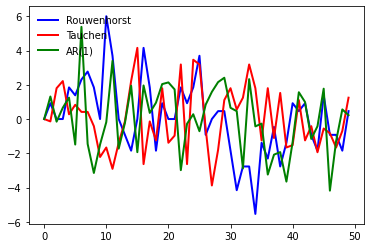

In [18]:
n = 101
alpha = 0.5
sigma_e = 2
steps = 50

AR = [0]
AR += [alpha*AR[-1] + np.random.normal(0,sigma_e) for i in range(steps-1)]
T = tauchen(n, sigma_e, alpha).simulate(steps,init=0)
R = rouwenhorst(n, sigma_e, alpha).simulate(steps,init=0)
    
series = [R, T, AR]
labels = ['Rouwenhorst','Tauchen', 'AR(1)']

fig, ax = plt.subplots(1, 1)
for s, label, c in zip(series, labels, ['b','r','g']):
    ax.plot(s, c, lw=2, label=label)
ax.legend(loc='upper left', frameon=False)
plt.show()

## Class for assets of the first type: constant dividends

In [19]:
class modell1:
    
    def __init__(self, d, β=0.9):
        
        warning_message = "Inappropriate discount factor."
        assert β < 1 and β > 0,  warning_message
        
        self.d = d
        self.β = β
        
    def __str__ (self):
        return 'Asset with dividend ' + str(self.d)
        
    def eq_price(self):
        
        p = self.β*self.d/(1 - self.β)
        self.p = p
    
        return self.p
        
    def simulate(self, steps):
        modell1.eq_price(self)
        print('The current equilibrium price is ' + str(self.p))
        
        d_series = [self.d for i in range(steps)]
        
        p_series = [self.p for i in range(steps)]


        series = [d_series, p_series]
        labels = ['dividends', 'prices']

        fig, axes = plt.subplots(1, 2)
        fig.set_size_inches(10, 2)
        for ax, s, label in zip(axes.flatten(), series, labels):
            ax.plot(s, 'b-', lw=2, label=label)
            ax.legend(loc='upper right', frameon=False)
        plt.tight_layout()
        plt.show()  

The current equilibrium price is 90.00000000000001


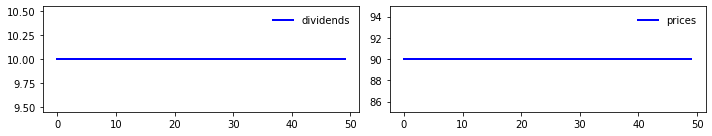

In [20]:
m1 = modell1(10)
m1.simulate(50)

## Class for assets of the second type: geometric series as dividends

In [21]:
class modell2:
    
    def __init__(self, d, g = 1, β=0.9):
        
        warning_message = "Inappropriate discount factor or dividend."
        assert β*g < 1 and β*g > 0 and β > 0,  warning_message
        
        self.d = d
        self.g = g
        self.β = β
        
    def __str__ (self):
        return 'Asset with first dividend' + str(self.d) + ' growing by ' + str(self.g)
        
    def eq_price(self, t = 1):
        
        p_t = (self.β*self.g/(1 - self.β*self.g))*self.d*self.g**t
    
        return p_t
    
        
    def simulate(self, steps):
        p = [modell2.eq_price(self, i) for i in range(1,steps+1)]
        self.p = p
        print('The current equilibrium price is ' + str(self.p[0]))
        
        d_series = [self.d*self.g**i for i in range(steps)]

        p_series = self.p

        series = [d_series, p_series]
        labels = ['dividends', 'prices']

        fig, axes = plt.subplots(1, 2)
        fig.set_size_inches(10, 2)
        for ax, s, label in zip(axes.flatten(), series, labels):
            ax.plot(s, 'b-', lw=2, label=label)
            ax.legend(loc='upper right', frameon=False)
        plt.tight_layout()
        plt.show()

The current equilibrium price is 114.1902439024391


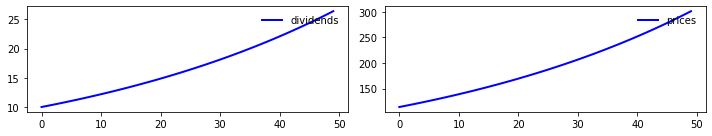

In [22]:
m2 = modell2(10, 1.02)
m2.simulate(50)

## Class for assets of the first type: Markov growth

In [23]:
class modell3:
    
    def __init__(self, d, method = tauchen, x0 = 0, g = np.exp, β=0.9):
        
        warning_message = "Inappropriate discount factor."
        assert β < 1 and β > 0,  warning_message
        
        self.d = d
        self.x0 = x0
        self.method = method
        self.g = g
        self.β = β
        
        n = 25
        self.mc = self.method(n, 0.01, 0.96)
        
        K = self.g(self.mc.state_values) * self.mc.P
        I = np.identity(n)

        warning_message = "Matrix is not invertible."
        assert np.max(np.abs(eigvals(K))) < 1 / β,  warning_message

        v = solve(I - self.β * K, self.β * K @ np.ones(n))
        V = {self.mc.state_values[i]: v[i] for i in range(n)}
        
        self.V = V
        
    def __str__ (self):
        return 'Asset with first dividend' + str(self.d) + ' growing by Markov growth '
        
    def eq_price(self, x = None, d = None):
        
        if x == None:
            x = self.x0       
        if d == None:
            d = self.d
        
        p = d*self.V[x]
    
        return p
    
        
    def simulate(self, steps, X = True, g = True, d = True, p = True):
        X_series = self.mc.simulate(steps, init = self.x0)
        g_series = self.g(X_series)
        d_series = self.d*np.cumprod(g_series)
        p_series = []
        for i in range(steps):
            x = X_series[i]
            d = d_series[i]
            p_series.append(modell3.eq_price(self, x, d))
            
        print('The current equilibrium price is '+ str(p_series[0]))

        verbose = [X, g, d, p]
        series = [X_series, g_series, d_series, p_series]
        labels = ['states','g function','dividends', 'prices']

        fig, axes = plt.subplots(2, 2)
        fig.set_size_inches(10, 4)
        for ax, s, label in zip(axes.flatten(), series, labels):
            ax.plot(s, 'b-', lw=2, label=label)
            ax.legend(loc='upper right', frameon=False)
        plt.tight_layout()
        plt.show()  

The current equilibrium price is 94.5185134172666


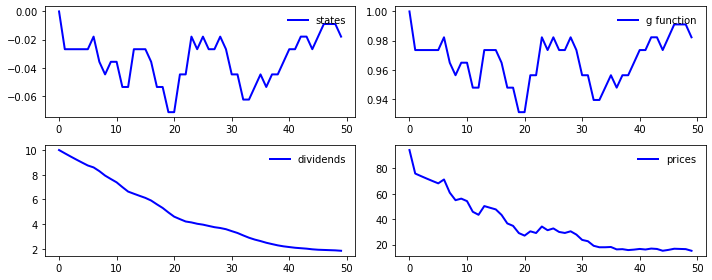

In [24]:
m3 = modell3(10)
m3.simulate(50)

The current equilibrium price is 94.25223144625915


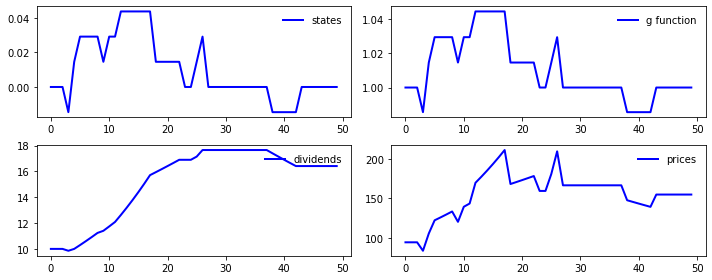

In [25]:
m4 = modell3(10, method = rouwenhorst)
m4.simulate(50)

In [26]:
data1 = {"state values" : ["{:.2f}".format(i) for i in m3.mc.state_values[:12]],
        "g function" : ["{:.2f}".format(i) for i in np.exp(m3.mc.state_values)[:12]],
        "price-dividend ratio" : ["{:.2f}".format(i) for i in list(m3.V.values())[:12]],
        "probability" : ["{:.1e}".format(i) for i in m3.mc.stationary_distributions[0][:12]]}
pd.DataFrame(data1).T.style.set_caption("Modell3 - Tauchen method")

,0,1,2,3,4,5,6,7,8,9,10,11
state values,-0.11,-0.10,-0.09,-0.08,-0.07,-0.06,-0.05,-0.04,-0.04,-0.03,-0.02,-0.01
g function,0.90,0.91,0.91,0.92,0.93,0.94,0.95,0.96,0.96,0.97,0.98,0.99
price-dividend ratio,4.96,5.13,5.35,5.61,5.90,6.22,6.56,6.94,7.36,7.81,8.30,8.85
probability,1.7e-03,2.7e-03,5.2e-03,9.0e-03,1.5e-02,2.3e-02,3.4e-02,4.7e-02,6.1e-02,7.4e-02,8.6e-02,9.4e-02


In [27]:
data2 = {"state values" : ["{:.2f}".format(i) for i in m3.mc.state_values[12:]],
        "g function" : ["{:.2f}".format(i) for i in np.exp(m3.mc.state_values)[12:]],
        "price-dividend ratio" : ["{:.2f}".format(i) for i in list(m3.V.values())[12:]],
        "probability" : ["{:.1e}".format(i) for i in m3.mc.stationary_distributions[0][12:]]}
pd.DataFrame(data2, index = [12 + i for i in range(13)]).T

,12,13,14,15,16,17,18,19,20,21,22,23,24
state values,0.00,0.01,0.02,0.03,0.04,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11
g function,1.00,1.01,1.02,1.03,1.04,1.05,1.06,1.06,1.07,1.08,1.09,1.10,1.11
price-dividend ratio,9.45,10.12,10.85,11.66,12.57,13.57,14.67,15.90,17.23,18.67,20.17,21.62,22.80
probability,9.7e-02,9.4e-02,8.6e-02,7.4e-02,6.1e-02,4.7e-02,3.4e-02,2.3e-02,1.5e-02,9.0e-03,5.2e-03,2.7e-03,1.7e-03


In [28]:
data3 = {"state values" : ["{:.2f}".format(i) for i in m4.mc.state_values[:12]],
        "g function" : ["{:.2f}".format(i) for i in np.exp(m4.mc.state_values)[:12]],
        "price-dividend ratio" : ["{:.2f}".format(i) for i in list(m4.V.values())[:12]],
        "probability" : ["{:.1e}".format(i) for i in m4.mc.stationary_distributions[0][:12]]}
pd.DataFrame(data3).T.style.set_caption("Modell3 - Rouwenhorst method")

,0,1,2,3,4,5,6,7,8,9,10,11
state values,-0.17,-0.16,-0.15,-0.13,-0.12,-0.10,-0.09,-0.07,-0.06,-0.04,-0.03,-0.01
g function,0.84,0.85,0.86,0.88,0.89,0.90,0.92,0.93,0.94,0.96,0.97,0.99
price-dividend ratio,3.54,3.77,4.02,4.31,4.62,4.98,5.38,5.84,6.37,6.97,7.67,8.48
probability,6.0e-08,1.4e-06,1.6e-05,1.2e-04,6.3e-04,2.5e-03,8.0e-03,2.1e-02,4.4e-02,7.8e-02,1.2e-01,1.5e-01


In [29]:
data4 = {"state values" : ["{:.2f}".format(i) for i in m4.mc.state_values[12:]],
        "g function" : ["{:.2f}".format(i) for i in np.exp(m4.mc.state_values)[12:]],
        "price-dividend ratio" : ["{:.2f}".format(i) for i in list(m4.V.values())[12:]],
        "probability" : ["{:.1e}".format(i) for i in m4.mc.stationary_distributions[0][12:]]}
pd.DataFrame(data4, index = [12 + i for i in range(13)]).T

,12,13,14,15,16,17,18,19,20,21,22,23,24
state values,0.00,0.01,0.03,0.04,0.06,0.07,0.09,0.10,0.12,0.13,0.15,0.16,0.17
g function,1.00,1.01,1.03,1.04,1.06,1.08,1.09,1.11,1.12,1.14,1.16,1.17,1.19
price-dividend ratio,9.43,10.54,11.86,13.43,15.32,17.59,20.35,23.71,27.83,32.92,39.23,47.09,56.95
probability,1.6e-01,1.5e-01,1.2e-01,7.8e-02,4.4e-02,2.1e-02,8.0e-03,2.5e-03,6.3e-04,1.2e-04,1.6e-05,1.4e-06,6.0e-08
